# Import Libraries


In [ ]:
!pip install emoji

!pip install transformers



     |████████████████████████████████| 175 kB 11.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=9801e05e9ff48ed5c8d6b4250da34cac2d797f9e530e182a2974db8c1d8a50f4
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 1.0 MB/s 
     |████████████████████████████████| 77 kB 2.8 MB/s 
     |████████████████████████████████| 6.5 MB 35.2 MB/s 
     |████████████████████████████████| 895 kB 29.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd 

import numpy as np 

import seaborn as sns

import datetime

import matplotlib.pyplot as plt; plt.rcdefaults() 

import os #Nik
from sklearn.model_selection import train_test_split


import csv #Nik

import regex as re

# from langdetect import detect

import emoji

from transformers import RobertaTokenizer, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import transformers
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
device = torch.device('cuda')
from sklearn.metrics import f1_score

In [ ]:
def convert_lists_to_tensors(tokens: transformers.tokenization_utils_base.BatchEncoding,
                             labels: pd.Series) -> list:
  """"
  Convert lists inside tokens to tensors
  """
  seq = torch.tensor(tokens['input_ids'])
  mask = torch.tensor(tokens['attention_mask'])
  y = labels.map({-1:[1,0,0],0:[0,1,0],1:[0,0,1]})
  y = torch.tensor(y.tolist(), dtype=torch.float)
  return seq, mask, y


def create_data_loader(seq: torch.tensor,
                       mask: torch.tensor,
                       y: torch.tensor,
                       batch_size: int=128) -> DataLoader:
  """
  Wrap all the tensor into a batched DataLoader
  """
  data = TensorDataset(seq, mask, y)
  ## sampler for sampling the data during training
  ## dataLoader for set
  #dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  dataloader = DataLoader(data, shuffle=False, batch_size=batch_size)
  return dataloader


def tokenize_and_encode_sequences(tokenizer: transformers.PreTrainedTokenizerFast, 
                                  input_text: pd.Series, 
                                  max_length: int=128) -> transformers.tokenization_utils_base.BatchEncoding:
  """
  Tokenize and encode sequences in the input_text set  
  """
  tokens = tokenizer.batch_encode_plus(
      input_text.tolist(),
      padding='max_length',
      max_length = max_length,
      truncation=True,                 
      add_special_tokens = True, # Add '[CLS]' and '[SEP]'  
      return_attention_mask = True
  )
  return tokens

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


##Import Dataset (KAGGLE Long Time Frame)

In [ ]:
dta_LT = pd.read_excel('/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/Kaggle_tweets_L_T_F_labelled.xlsx',index_col=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


###Data Pre-processing & Cleaning 


In [ ]:
def preprocess_dataset(df,drop_duplicate=True):
    """
    Cleaning Tweet

    Args:
      df : a dataframe
      drop_duplicate : 
    
    Returns:
      df : a dataframe with an extra clean_tweet column

    """
    #takes as input 'text' column
    n_rows = len(df)

    # Delete Rows with NaN (where tweet is deleted)
    
    df.dropna(subset=['text'],inplace=True)
    print(f'Dropped {n_rows - len(df)} NaN rows')
    #overwrite n_rows

    # Check for and remove duplicates 
    
    # Converting all tweets to lower case 
    df['clean_tweet'] = df.text.str.lower()

    # Replace Username to "@user"
    df['clean_tweet'] = df.clean_tweet.apply(lambda x: re.sub('\@[a-zA-Z0-9]*', '@user', x))

    # Replace Links with ""
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'{link}', '', x))
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"\[video\]", '', x))

    # Replace "RT @" with "@" this is referring to Retweet
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.compile('rt @').sub('@', x).strip())

    # Remove "#" and but keep the word that follows ### (and also when word starts with $)
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: x.replace("#", "").replace("_", " ").replace(":",""))
    
    #df = df.apply(lambda x: re.sub('\$[a-zA-Z0-9]*', '\[a-zA-Z0-9]*', x)) ### Look at it later

    # Change all emojis to Text
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x : emoji.demojize(x,language='en'))

    if drop_duplicate:
      n_rows = len(df)
      df.drop_duplicates(subset=['clean_tweet'],keep='first',inplace=True)
      print(f'Dropped {n_rows - len(df)} duplicate tweets')

    return df

In [ ]:
dta_final = preprocess_dataset(dta_LT)

Dropped 0 NaN rows
Dropped 86 duplicate tweets


In [ ]:
# setting tweets with non bullish or bearish sentiment to neutral
dta_final.loc[dta_final['kind']=='project','sentiment'] = 0
dta_final.loc[dta_final['kind']=='ad','sentiment'] = 0
dta_final.loc[dta_final['kind']=='NFT','sentiment'] = 0
dta_final.loc[dta_final['kind']=='nft','sentiment'] = 0

EDA

In [ ]:
dta_final.sentiment.value_counts()

 0.0    1131
 1.0     826
-1.0     257
Name: sentiment, dtype: int64

**Resources used:** 
- https://huggingface.co/cardiffnlp/twitter-roberta-base
- https://github.com/Data-Science-kosta/Twitter-Sentiment-Analysis-RoBERTa/blob/main/SA_dataset1.ipynb



Pytorch DataSet

In [ ]:
# # example train test split
# train_text, test_text, train_labels, test_labels = train_test_split(dta_final['clean_tweet'], dta_final['sentiment'], 
#                                                                     random_state=1890, 
#                                                                     test_size=0.2, 
#                                                                     stratify=dta_final['sentiment'])

In [ ]:
# test_index = test_text.index
# valid_set = dta_final.loc[dta_final.index.isin(test_index)]
# valid_set.to_csv("/content/gdrive/My Drive/NLP Group Project (2022)/roberta_valid_set.csv")

In [ ]:
# train_index = train_text.index
# train_set = dta_final.loc[dta_final.index.isin(train_index)]
# train_set.to_csv("/content/gdrive/My Drive/NLP Group Project (2022)/roberta_train_set.csv")

In [ ]:
train_set = pd.read_csv("/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/roberta_train_set.csv",index_col=0)
valid_set = pd.read_csv("/content/gdrive/My Drive/NLP Group Project (2022)/tweet_datasets/roberta_valid_set.csv",index_col=0)
train_text = train_set['clean_tweet']
valid_text = valid_set['clean_tweet']
train_labels = train_set['sentiment']
valid_labels = valid_set['sentiment']

In [ ]:
all = pd.concat([train_labels,valid_labels])
all.value_counts()/len(all) * 100

 0.0    51.519214
 1.0    36.997319
-1.0    11.483467
Name: sentiment, dtype: float64

# Tokenizing Text

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 64
batch_size = 32

tokens_train = tokenize_and_encode_sequences(roberta_tokenizer,
                                             train_text,
                                             max_length=max_length)
tokens_valid = tokenize_and_encode_sequences(roberta_tokenizer,
                                            valid_text,
                                            max_length=max_length)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
cws = compute_class_weight(class_weight='balanced',classes=np.unique(train_labels),y=train_labels)
print(cws)

class_weights = torch.tensor(cws).to(device)

[2.89644013 0.64714389 0.90130916]


In [ ]:
train_seq, train_mask, train_y = convert_lists_to_tensors(tokens_train, train_labels)
valid_seq, valid_mask, valid_y = convert_lists_to_tensors(tokens_valid, valid_labels)

In [ ]:
train_dataloader = create_data_loader(train_seq, train_mask, train_y, batch_size=batch_size)
valid_dataloader = create_data_loader(valid_seq, valid_mask, valid_y, batch_size=batch_size)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
                                                      num_labels = 3, # The number of output labels--2 for binary classification.
                                                      output_attentions = False, # Whether the model returns attentions weights.
                                                      output_hidden_states = False, # Whether the model returns all hidden-states.
                                                      problem_type="multi_label_classification"
)
model.cuda()
model.to(device)

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 3e-6)# learning rate
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_default(class_weights):
  """
  Train Created Model
  """
  model.train()
  #print(model.name)
  total_loss = 0
  # empty list to save model predictions
  total_preds=[]
  true_labels_list = []
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # push the batch to gpu|
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    outputs = model(sent_id, 
                      token_type_ids=None, 
                      attention_mask=mask, 
                      labels=labels,
                      return_dict=True)

    logits = outputs['logits']
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = criterion(logits,labels)

    total_loss = total_loss + loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(),  max_norm=1.0)
    optimizer.step()

    scheduler.step()
    preds = logits.detach().cpu()
    total_preds.append(preds)
    true_labels_list.append(labels)

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    
  avg_loss = total_loss / len(train_dataloader)
  train_preds = torch.cat(total_preds).detach().cpu()
  
  m = nn.Softmax(dim=1)
  output = m(train_preds)
  train_labels = torch.cat(true_labels_list).detach().cpu().numpy()
  true_y = train_labels.argmax(axis=1) - 1
  pred_y = output.argmax(axis=1) - 1
  train_f1_score = f1_score(true_y, pred_y ,average=None)
  print("Training F1 score",train_f1_score)

  return avg_loss


In [ ]:
# function for evaluating the model
def evaluate_epoch(class_weights):
  
  print("\nEvaluating...")
  model.eval()

  total_loss = 0
  total_preds = []
  true_labels_list = []

  with torch.no_grad():
    for step,batch in enumerate(valid_dataloader):     
      batch = [t.to(device) for t in batch]
      sent_id, mask, labels = batch
      # deactivate autograd
      
      outputs = model(sent_id, 
                      token_type_ids=None, 
                      attention_mask=mask, 
                      labels=labels,
                      return_dict=True)

      logits = outputs['logits']
      criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
      loss = criterion(logits,labels)
      preds = logits.detach().cpu()
      total_preds.append(preds)
      true_labels_list.append(labels)

      # total_preds.append(preds)
      total_loss = total_loss + loss.item()
      avg_loss = total_loss / len(valid_dataloader)
    test_preds = torch.cat(total_preds).detach().cpu()
    m = nn.Softmax(dim=1)
    output = m(test_preds)
    valid_labels = torch.cat(true_labels_list).detach().cpu().numpy()
    true_y = valid_labels.argmax(axis=1) - 1
    pred_y = output.argmax(axis=1) - 1
    valid_f1_score = f1_score(true_y, pred_y ,average=None)
    print("Validation F1 score",valid_f1_score)

  return avg_loss

# Fine Tuning

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses_bert=[]
valid_losses_bert=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss = train_default(class_weights)
    #evaluate model
    valid_loss = evaluate_epoch(class_weights)


    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), "/content/gdrive/My Drive/NLP Group Project (2022)/fine-tuning_roberta/roberta_for_classification5.pt")
    # append training and validation loss
    train_losses_bert.append(train_loss)
    valid_losses_bert.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')




 Epoch 1 / 20
  Batch    50  of     56.
Training F1 score [0.11971831 0.72385621 0.26886792]

Evaluating...
Validation F1 score [0.10526316 0.68367347 0.60280374]

Training Loss: 1.000
Validation Loss: 0.987

 Epoch 2 / 20
  Batch    50  of     56.
Training F1 score [0.32713755 0.73738532 0.49152542]

Evaluating...
Validation F1 score [0.34677419 0.65745856 0.36363636]

Training Loss: 0.932
Validation Loss: 0.923

 Epoch 3 / 20
  Batch    50  of     56.
Training F1 score [0.38018742 0.74178404 0.40921169]

Evaluating...
Validation F1 score [0.35294118 0.6961039  0.35164835]

Training Loss: 0.865
Validation Loss: 0.863

 Epoch 4 / 20
  Batch    50  of     56.
Training F1 score [0.45803698 0.76294591 0.48112379]

Evaluating...
Validation F1 score [0.40816327 0.73945409 0.45791246]

Training Loss: 0.791
Validation Loss: 0.814

 Epoch 5 / 20
  Batch    50  of     56.
Training F1 score [0.56117455 0.78567368 0.61754967]

Evaluating...
Validation F1 score [0.51351351 0.74371859 0.60571429]


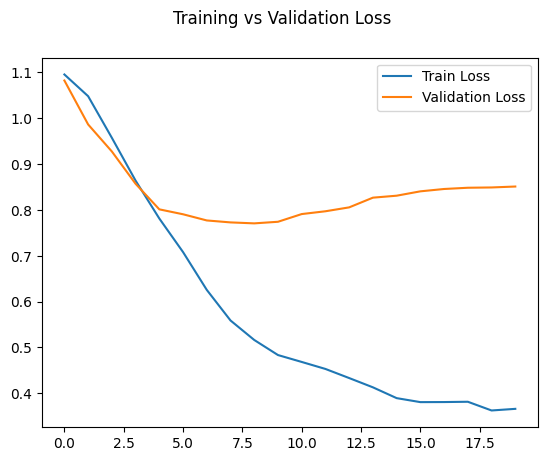

In [ ]:
plt.figure()
plt.plot(train_losses_bert,label='Train Loss')
plt.plot(valid_losses_bert,label='Validation Loss')
plt.legend()
plt.suptitle("Training vs Validation Loss")
# plt.savefig("/content/gdrive/My Drive/NLP Group Project (2022)/fine-tuning_roberta/roberta_loss_curve.png")